In [3]:
import os
current_path = os.getcwd()
current_path

'C:\\Users\\SHALAKA'

In [4]:
#Importing all the necessary libraries
import os
import pandas as pd, csv
import numpy as np
import re
from scipy import spatial
#import tensorflow as tf
import random
import nltk
from nltk import word_tokenize as tokenize
import transformers
from transformers import pipeline
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import random
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)
import ast
import pandas as pd, csv
from nltk import word_tokenize as tokenize


In [5]:
#Path for the dataset
TRAINING_DIR="C:\\Users\\SHALAKA\\Downloads\\NLP lab2\\lab2resources\\sentence-completion\\Holmes_Training_Data"

# Function to split the data into training and hedloutfiles
#Used random seed to set the spilitting of files same everytime 
def get_training_testing(training_dir,split=0.5):

    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)
    random.shuffle(filenames)
    index=int(n*split)
    trainingfiles=filenames[:index]
    heldoutfiles=filenames[index:]
    return trainingfiles,heldoutfiles


In [6]:
# Class for implementing N-gram Model
# vailable known is used for handling OOV words
# discount is set to 0.75 for Kneser-Ney smoothing
class language_model():
    
    def __init__(self,trainingdir=TRAINING_DIR,files=[],known = 2,discount = 0.75):
        self.training_dir=trainingdir
        self.files=files
        self.train()
        self.known = known
        self.discount = discount
        
#dictionaries for unigram, bigram and trigram   
    def train(self):    
        self.unigram={}
        self.bigram={}
        self.trigram={}
         
        self._processfiles()
        self._make_unknowns()
        self._discount()
        self._kneser_ney()
        
        
        self._convert_to_probs()
#this function adds __START and __END to each line during tokenization
#function to get tokens for unigram, bigram and trigram
    def _processline(self,line):
        tokens=["_START"]+tokenize(line)+["_END"]
        previous="__END"
        i = 0
        for token in tokens:
            self.unigram[token]=self.unigram.get(token,0)+1
            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current
            previous=token
            if i < len(tokens)-2:#checks the length of tokens for generating trigram tokens
              # Next words.
                next = tokens[i+1] 
                next_next = tokens[i+2]
                # Get dictionaries.
                inner = self.trigram.get(token,{})
                innermost = inner.get(next,{})
                innermost[next_next] = innermost.get(token,0) + 1
                # Write frequencies to dictionaries.
                inner[next] = innermost
                self.trigram[token] = inner                 

# Function to to process the files
    def _processfiles(self):
        for afile in self.files:
            print("Processing {}".format(afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            self._processline(line)
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
      
    #Function to convert the words into the from the unigram, bigram and trigram tokens and Kneser-Ney Smoothing
    def _convert_to_probs(self):
        
        self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram={k1:{k2:{k3:v/sum(adict2.values()) for k3, v in adict2.items()} for k2, adict2 in adict1.items()} for k1, adict1 in self.trigram.items()}
       
        self.kn={k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
        
     #Function to get the probabilities as per model selection   
    def get_prob(self,token,context="",methodparams={}):
        if methodparams.get("method","unigram")=="unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))
        else:
            if methodparams.get("smoothing","kneser-ney")=="kneser-ney":
                unidist=self.kn
            else:
                unidist=self.unigram
            bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
            big_p=bigram.get(token,bigram.get("__UNK",0))
            lmbda=bigram["__DISCOUNT"]
            uni_p=unidist.get(token,unidist.get("__UNK",0))
            #print(big_p,lmbda,uni_p)
            p=big_p+lmbda*uni_p            
            return p
    
    # Generate the next likeyly tokens sequence as per the method requested
    def nextlikely(self,k=1,current="",method="unigram"):
        #use probabilities according to method to generate a likely next sequence
        #choose random token from k best
        blacklist=["_START","UNK","_DISCOUNT"]
       
        if method=="unigram":
            dist=self.unigram
        elif method=="bigram":
            dist=self.bigram.get(current,self.bigram.get("__UNK",{}))
        else :
            # Split context string for first and second context words.
            context = current.split()
            c1, c2 = context[0], context[1]
            dist = self.trigram[c1][c2]
            # Get all words with maximum value.
            most_likely = [(k, _) for k, v in dist.items() if v == max(dist.values())]
    
        #sort the tokens by unigram probability
        mostlikely=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
        #filter out any undesirable tokens
        filtered=[w for (w,p) in mostlikely if w not in blacklist]
        #choose one randomly from the top k
        res=random.choice(filtered[:k])
        return res
    
    def generate(self,k=1,end="__END",limit=20,method="bigram",methodparams={}):
        if method=="":
            method=methodparams.get("method","bigram")
        current="__START"
        tokens=[]
        try:
            
            if method=="trigram":
            # Set current word to first context.
                context_1 = current
            # Set random choice of next word to second context.
                context_2 = random.choice([key for key, adict in self.trigram[current].items()])
            # Check end token hasnt been reached.
                while context_2 != end and len(tokens)<limit:
              # Pass current contexts to next likely method which re splits them in the tri- 4-gram cases.
                    current = " ".join([context_1, context_2])
                    current = self.nextlikely(k=k, current=current, method=method)
                # Append word to the list that will eventually be generated.
                    tokens.append(current)
                # Set the the second context to now be first and the predicted word (current) to be next.
                    context_1 = context_2
                    context_2 = current
            # After loop return the tokens joined by whitespace.
                return " ".join(tokens[:-1])
        except:
          # If error is thrown rerun method until it generates a valid sentence.
              return self.generate(k=k,end=end,limit=limit,method=method,methodparams=methodparams)
        while current!=end and len(tokens)<limit:
                current=self.nextlikely(k=k,current=current,method=method)
                tokens.append(current)
        return " ".join(tokens[:-1])
    def compute_prob_line(self,line,methodparams={}):
       
        #Refactored method which calls get_probs() for uni- and bigram cases.
         
        
        #this will add _start to the beginning of a line of text
        #compute the probability of the line according to the desired model
        #and returns probability together with number of tokens
        
        
        acc=0
        if methodparams.get("method", "unigram") in ["unigram", "bigram"]:
            for i,token in enumerate(tokens[1:]):
                acc+=math.log(self.get_prob(token,tokens[:i+1],methodparams))
            return acc,len(tokens[1:])
        # compute probability for Trigram. 
        if methodparams.get("method") == "trigram":
            try:
                for i, token in enumerate(tokens[1:]):
                    if i < len(tokens[1:]) - 3 and len(tokens[1:]) >= 3:
                        word1, word2, word3 = tokens[i+1], tokens[i+1+1], tokens[i+1+2]
                        if word1 in self.trigram:
                            if word2 in self.trigram[word1]:
                                if word3 in self.trigram[word1][word2]:
                                      acc+=math.log(self.trigram[word1][word2][word3])
                                else:
                                      acc+=math.log(self.trigram[word1][word2]["__UNK"])
                            else:
                                if word3 in self.trigram[word1]["__UNK"]:
                                      acc+=math.log(self.trigram[word1]["__UNK"][word3])
                                else: 
                                      acc+=math.log(self.trigram[word1]["_UNK"]["_UNK"])
                        else:
                            if word2 in self.trigram["__UNK"]:
                                if word3 in self.trigram["__UNK"][word2]:
                                        acc+=math.log(self.trigram["__UNK"][word2][word3])
                                else:
                                        acc+=math.log(self.trigram["_UNK"][word2]["_UNK"])
                            else:
                                if word3 in self.trigram["_UNK"]["_UNK"]:
                                      acc+=math.log(self.trigram["_UNK"]["_UNK"][word3])
                                else:
                                      acc+=math.log(self.trigram["_UNK"]["UNK"]["_UNK"])
                return acc, len(tokens[1:])
            except KeyError:
                return acc, len(tokens[1:]) 
    
   
    def compute_probability(self,filenames=[],methodparams={}):
        #computes the probability and length of a corpus contained in filenames
        if filenames==[]:
            filenames=self.files
        
        total_p=0
        total_N=0
        for i,afile in enumerate(filenames):
            print("Processing file {}:{}".format(i,afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            p,N=self.compute_prob_line(line,methodparams=methodparams)
                            total_p+=p
                            total_N+=N
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    # Funtcion to calculate perplexity
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        
        p,N=self.compute_probability(filenames=filenames,methodparams=methodparams)
        # print(p,N)
        if methodparams.get("method") in ["trigram"]:
            rem = self.super_counter[methodparams.get("method")] - self.magic_counter[methodparams.get("method")]
            pp=math.exp(-p/N) * (self.super_counter[methodparams.get("method")]/rem)
            return pp
        pp=math.exp(-p/N)
        return pp  
    
   
    # Function to handle OOV words and replace the oVV words with "UNK" token
    def _make_unknowns(self,known=2):
        unknown=0
        self.number_unknowns=0
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["_UNK"]=self.unigram.get("_UNK",0)+v
                self.number_unknowns+=1
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["_UNK"]=adict.get("_UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
                
            else:
                self.bigram[k]=adict
# # below code is for handling OOV words for Trigram 
        for (k1, dict1) in list(self.trigram.items()):
            for (k2, dict2) in list(dict1.items()):
                for (k3, val) in list(dict2.items()):
                    isknown=self.unigram.get(k3,0)
                    if isknown == 0:
                        dict2["_UNK"] = dict2.get("_UNK",0) + val
                        del dict2[k3]
                isknown=self.unigram.get(k2,0)
                if isknown <= known:
                    del self.trigram[k1][k2]
                    current=self.trigram[k1].get("__UNK",{})
                    current.update(dict2)
                    self.trigram[k1]["__UNK"] = current
                else:
                    self.trigram[k1][k2] = dict2
          # For first token:
                    isknown=self.unigram.get(k1,0)
            if isknown <= known:
                del self.trigram[k1]
                current = self.trigram.get("__UNK",{})
                current.update(dict1)
                self.trigram["__UNK"] = current 
            else:
                self.trigram[k1] = dict1
    
    
    #Function to calculate discount for smoothing
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}
        
        #for each word, stores the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb=len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"]=lamb*discount
               
    def _kneser_ney(self):

        self.kn={}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk]=self.kn.get(kk,0)+1

In [7]:
#Splitting the data into training and testing sets
#giving call to the language_model() for the splitting the data
parentdir="C:\\Users\\SHALAKA\\Downloads\\NLP lab2\\lab2resources\\sentence-completion" #you may need to update this 

trainingdir=os.path.join(parentdir,"Holmes_Training_Data")
training,testing=get_training_testing(trainingdir)
MAX_FILES=20  
mylm=language_model(trainingdir=trainingdir,files=training[:MAX_FILES])

There are 522 files in the training directory: C:\Users\SHALAKA\Downloads\NLP lab2\lab2resources\sentence-completion\Holmes_Training_Data
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Processing RNDBY10.TXT
Processing LAMEP10.TXT
Processing OAKDA10.TXT
Processing TGAMT210.TXT
Processing MSBIM10.TXT
Processing ALAMO10.TXT
Processing FRCUP10.TXT
Processing NABBY10.TXT
Processing THEEU10.TXT
Processing SNYBK10.TXT
Processing TLTTF10.TXT
Processing STROQ10.TXT
Processing LDASC10.TXT


In [8]:
# Storing the questions from testing_data file to variable questions
# Storing the aswers from test_answer file to vaiable answers
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [33]:
#tokenizing the questions 
tokens=[tokenize(q) for q in qs_df['question']]
print(tokens)

[['I', 'have', 'it', 'from', 'the', 'same', 'source', 'that', 'you', 'are', 'both', 'an', 'orphan', 'and', 'a', 'bachelor', 'and', 'are', '_____', 'alone', 'in', 'London', '.'], ['It', 'was', 'furnished', 'partly', 'as', 'a', 'sitting', 'and', 'partly', 'as', 'a', 'bedroom', ',', 'with', 'flowers', 'arranged', '_____', 'in', 'every', 'nook', 'and', 'corner', '.'], ['As', 'I', 'descended', ',', 'my', 'old', 'ally', ',', 'the', '_____', ',', 'came', 'out', 'of', 'the', 'room', 'and', 'closed', 'the', 'door', 'tightly', 'behind', 'him', '.'], ['We', 'got', 'off', ',', '_____', 'our', 'fare', ',', 'and', 'the', 'trap', 'rattled', 'back', 'on', 'its', 'way', 'to', 'Leatherhead', '.'], ['He', 'held', 'in', 'his', 'hand', 'a', '_____', 'of', 'blue', 'paper', ',', 'scrawled', 'over', 'with', 'notes', 'and', 'figures', '.'], ['Finally', 'he', 'returned', 'to', 'the', 'pawnbroker', "'s", ',', 'and', ',', 'having', 'thumped', 'vigorously', 'upon', 'the', 'pavement', 'with', 'his', '_____', 'two',

In [34]:
print("The total number of tokens is: ", len(tokens))

The total number of tokens is:  1040


In [23]:
# Chceking the tokens generated by trigram model
mylm.trigram["told"]

{'sufficiently': {'revived': 1.0},
 'was': {'in': 0.058823529411764705,
  'told': 0.23529411764705882,
  'playing': 0.11764705882352941,
  'marked': 0.17647058823529413,
  ',': 0.17647058823529413,
  'now': 0.23529411764705882},
 'What': {'answer': 0.3333333333333333,
  'Willie': 0.3333333333333333,
  'Clifford': 0.3333333333333333},
 'told': {'him': 0.047619047619047616,
  'their': 0.047619047619047616,
  'of': 0.047619047619047616,
  ',': 0.047619047619047616,
  'it': 0.047619047619047616,
  'me': 0.047619047619047616,
  'Isabella': 0.047619047619047616,
  'the': 0.047619047619047616,
  'you': 0.047619047619047616,
  'Phil': 0.047619047619047616,
  'to': 0.047619047619047616,
  'that': 0.047619047619047616,
  ';': 0.047619047619047616,
  'her': 0.047619047619047616,
  'them': 0.047619047619047616,
  'his': 0.047619047619047616,
  'your': 0.047619047619047616,
  'in': 0.047619047619047616,
  'himself': 0.047619047619047616,
  'Billy': 0.047619047619047616,
  'Mrs.': 0.0476190476190476

In [27]:
n = mylm.unigram["_UNK"]
print("The probability of a unknown word in unigram is: ", n)

The probability of a unknown word in unigram is:  0.010315319367611339


In [28]:
bigram_uk =len( mylm.bigram["__UNK"])
print("Number of times unknown word occured in a bigram : ", bigram_uk)

Number of times unknown word occured in a bigram :  2404


In [38]:
trigram_uk =len(mylm.trigram["__UNK"])
print("Number of times unknown word occured in a trigram : ", trigram_uk)


Number of times unknown word occured in a trigram :  10521


In [44]:
# Function to generate words form left context
def get_left_context(sent_tokens,window,target="_____"):
    found=-1
    #print(window)
    for i,token in enumerate(sent_tokens):
        if token==target:
            found=i
            break 
            
    if found>-1:
        return sent_tokens[i-window:i]
    else:
        return []
    

qs_df['tokens']=qs_df['question'].map(tokenize)
qs_df['left_context']=qs_df['tokens'].map(lambda x: get_left_context(x,3))
qs_df.head() 

,id,question,a),b),c),d),e),tokens,left_context
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[I, have, it, from, the, same, source, that, y...","[bachelor, and, are]"
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[It, was, furnished, partly, as, a, sitting, a...","[with, flowers, arranged]"
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,"[As, I, descended, ,, my, old, ally, ,, the, _...","[ally, ,, the]"
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,"[We, got, off, ,, _____, our, fare, ,, and, th...","[got, off, ,]"
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,"[He, held, in, his, hand, a, _____, of, blue, ...","[his, hand, a]"


In [45]:
#Function to generate words from right context
def get_right_context(self,window=1,target="_____"):
        found=-1
        sent_tokens=self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token==target:
                found=i
                break  
          
        if found>-1:
            
            return sent_tokens[found+1:found+window+1]
           
        else:
            return []

In [46]:
# Class for the questions for sentence completion challenge
# tokens with __START and __END in each lines are genearted
#functions to select the left or right context
class question:
    def __init__(self,aline):
        self.fields=aline
  
    def get_field(self,field):
        return self.fields[question.colnames[field]]
  
    def add_answer(self,fields):
        self.answer=fields[1]

    def get_tokens(self):
        return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]

    def get_left_context(self,window=1,target="_____"):
        found = -1
        sent_tokens = self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token == target:
                found = i
                break  
        
        if found >- 1:
            return sent_tokens[i-window:i]
        else:
            return []

    def get_right_context(self,window=1,target="_____"):
        found = -1
        sent_tokens = self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token == target:
                found = i
                break  
      
        if found >- 1:
            return sent_tokens[found + 1:found + window + 1]
        
        else:
            return []

  # Function to Choose modeland calculate probability
    def choose(self,lm,method="bigram",smoothing="Kneser-ney", choices=[]):
        if choices == []:
            choices = ["a","b","c","d","e"]

        if method == "bigram":
            rc = self.get_right_context(window=1)
            lc = self.get_left_context(window=1)
            probs = [lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) * lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]

        elif method == "trigram":
            rc = self.get_right_context(window=2)
            lc = self.get_left_context(window=2)
            probs = [lm.get_prob(self.get_field(ch+")"), lc, methodparams={"method":method.split("_")[0], "smoothing":smoothing})
              * lm.get_prob(rc[0], [lc[-1]] + [self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing})
              * lm.get_prob(rc[1], [self.get_field(ch+")")] + [rc[0]],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]
    
        else:
            context = self.get_left_context(window=1)
            probs = [lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
        # Select the word with max probability
        maxprob = max(probs)
        bestchoices = [ch for ch,prob in zip(choices,probs) if prob == maxprob]
        
        # if probabilities of the words are equal, select any word randomly
        return np.random.choice(bestchoices), probs
    # Function to predict
    def predict(self,lm,method="bigram", smoothing="kneser-ney"):
        return self.choose(lm,method=method,smoothing=smoothing,choices=[])
    #Function for prediction and accuracy
    def predict_and_score(self,lm,method="bigram", smoothing="kneser-ney"):
        prediction, probs = self.predict(lm,method=method,smoothing=smoothing)

        if prediction == self.answer:
            return 1, prediction, probs
        else:
            return 0, prediction, probs


    
    


In [47]:
#class to read question and answer files
#this class creates acsv file of the answers generated from unigram, bigram and trigram model
#calculates the probabilities and score

class scc_reader:
    
    def __init__(self,qs=questions,ans=answers):
        self.qs=qs
        self.ans=ans
        self.read_files()
    
    def read_files(self):
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)

        question.colnames={item:i for i,item in enumerate(qlines[0])}
        
        self.questions=[question(qline) for qline in qlines[1:]]
    
    
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
        
     
        for q,aline in zip(self.questions,alines[1:]):
              q.add_answer(aline)
    def get_field(self,field):
        return [q.get_field(field) for q in self.questions] 
  
    def predict(self,method="bigram"):
        return [q.predict(method=method) for q in self.questions]
  #Function to predict the probability and score
    def predict_and_score(self,lm,method="bigram",smoothing="kneser-ney"):
   
        predictions = []
        scores = []
        total_probs = []
        for q in self.questions:
            score, pred, probs = q.predict_and_score(lm,method=method, smoothing=smoothing)
            scores.append(score)
            predictions.append(pred)
            total_probs.append(probs)

        return sum(scores)/len(scores), predictions, total_probs

In [59]:
# answers for trigram model 
SCC=scc_reader()
SCC.predict_and_score(mylm,method="trigram")

(0.25576923076923075,
 ['a',
  'e',
  'b',
  'c',
  'c',
  'e',
  'a',
  'c',
  'e',
  'a',
  'd',
  'b',
  'e',
  'c',
  'd',
  'a',
  'e',
  'a',
  'b',
  'e',
  'c',
  'b',
  'a',
  'e',
  'a',
  'c',
  'c',
  'e',
  'd',
  'd',
  'c',
  'c',
  'b',
  'd',
  'e',
  'e',
  'a',
  'd',
  'd',
  'a',
  'c',
  'c',
  'e',
  'd',
  'd',
  'b',
  'a',
  'e',
  'c',
  'd',
  'b',
  'b',
  'b',
  'e',
  'a',
  'e',
  'b',
  'c',
  'a',
  'b',
  'a',
  'e',
  'c',
  'b',
  'd',
  'a',
  'e',
  'c',
  'c',
  'a',
  'b',
  'e',
  'd',
  'd',
  'd',
  'c',
  'c',
  'b',
  'c',
  'a',
  'a',
  'c',
  'd',
  'c',
  'e',
  'd',
  'c',
  'd',
  'a',
  'a',
  'b',
  'a',
  'c',
  'c',
  'a',
  'd',
  'b',
  'c',
  'a',
  'd',
  'b',
  'e',
  'e',
  'a',
  'c',
  'c',
  'c',
  'c',
  'e',
  'd',
  'd',
  'd',
  'd',
  'c',
  'b',
  'b',
  'e',
  'd',
  'e',
  'd',
  'a',
  'a',
  'c',
  'e',
  'b',
  'a',
  'e',
  'b',
  'e',
  'c',
  'b',
  'a',
  'c',
  'b',
  'd',
  'e',
  'a',
  'b',
  'a',
  'd'

In [57]:
# answers for bigram model 
SCC=scc_reader()
SCC.predict_and_score(mylm,method="bigram")

(0.2586538461538462,
 ['a',
  'e',
  'b',
  'c',
  'c',
  'e',
  'a',
  'c',
  'e',
  'a',
  'd',
  'b',
  'e',
  'c',
  'd',
  'a',
  'e',
  'a',
  'b',
  'e',
  'c',
  'b',
  'a',
  'e',
  'a',
  'c',
  'c',
  'e',
  'd',
  'd',
  'c',
  'c',
  'b',
  'd',
  'e',
  'e',
  'a',
  'd',
  'd',
  'a',
  'c',
  'c',
  'e',
  'd',
  'd',
  'b',
  'd',
  'e',
  'c',
  'd',
  'b',
  'b',
  'b',
  'e',
  'a',
  'e',
  'b',
  'c',
  'a',
  'b',
  'a',
  'e',
  'c',
  'b',
  'd',
  'a',
  'e',
  'c',
  'c',
  'a',
  'b',
  'e',
  'd',
  'd',
  'd',
  'c',
  'c',
  'b',
  'c',
  'a',
  'a',
  'c',
  'd',
  'c',
  'e',
  'd',
  'c',
  'd',
  'a',
  'a',
  'b',
  'a',
  'c',
  'c',
  'a',
  'd',
  'b',
  'c',
  'a',
  'd',
  'b',
  'e',
  'e',
  'a',
  'c',
  'c',
  'c',
  'c',
  'e',
  'd',
  'd',
  'd',
  'd',
  'c',
  'b',
  'b',
  'e',
  'd',
  'e',
  'd',
  'a',
  'a',
  'c',
  'e',
  'b',
  'a',
  'e',
  'b',
  'e',
  'c',
  'b',
  'a',
  'c',
  'b',
  'd',
  'e',
  'a',
  'b',
  'a',
  'd',

In [58]:
# answers for unigram model
SCC=scc_reader()
SCC.predict_and_score(mylm,method="unigram")

(0.18846153846153846,
 ['b',
  'd',
  'a',
  'a',
  'b',
  'c',
  'a',
  'b',
  'a',
  'e',
  'a',
  'e',
  'd',
  'e',
  'c',
  'a',
  'd',
  'a',
  'd',
  'e',
  'a',
  'c',
  'e',
  'e',
  'b',
  'c',
  'c',
  'a',
  'e',
  'a',
  'a',
  'e',
  'e',
  'a',
  'e',
  'b',
  'c',
  'c',
  'd',
  'b',
  'b',
  'c',
  'c',
  'c',
  'e',
  'c',
  'c',
  'd',
  'a',
  'e',
  'b',
  'd',
  'd',
  'e',
  'a',
  'a',
  'b',
  'c',
  'a',
  'd',
  'e',
  'e',
  'd',
  'c',
  'e',
  'd',
  'e',
  'e',
  'c',
  'e',
  'd',
  'c',
  'a',
  'b',
  'e',
  'a',
  'b',
  'c',
  'b',
  'e',
  'e',
  'a',
  'a',
  'e',
  'd',
  'd',
  'd',
  'b',
  'd',
  'c',
  'b',
  'e',
  'e',
  'e',
  'c',
  'a',
  'e',
  'c',
  'c',
  'e',
  'a',
  'b',
  'a',
  'd',
  'c',
  'b',
  'e',
  'b',
  'e',
  'd',
  'e',
  'd',
  'b',
  'c',
  'e',
  'd',
  'b',
  'c',
  'a',
  'c',
  'b',
  'a',
  'c',
  'd',
  'c',
  'a',
  'a',
  'c',
  'a',
  'e',
  'e',
  'b',
  'c',
  'a',
  'c',
  'b',
  'c',
  'e',
  'a',
  'd'

Hyper parameter tuning

In [60]:
#Hyper parameter tuning by using Kneser-Nay Smoothing
# known values are stores in list which will iterate in every run
#discount is set to 0.75
#number_files is a variable which will iterate number of files in every run
#results, predictions and total probability will be stored in list

files = os.listdir(trainingdir)
number_files = np.linspace(10, 100, 3).astype(int)
known = [2, 3, 4]
discount = 0.75
smoothing = 'kneser-ney'
MAX_FILES = 2
results = []
predictions = []
total_probs = []
iter = 0
for n in number_files:
    for k in known:
        print('Processing {} documents...'.format(n))
        mymodel = language_model(known = k, discount = discount, files =  files[:n])
        SCC = scc_reader(questions, answers)
    
        unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing=smoothing)
        bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mymodel,method="bigram",smoothing=smoothing)
        trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mymodel,method="trigram",smoothing=smoothing)
    
        results.append((n, k, unigram_accuracy,bigram_accuracy, trigram_accuracy))
        predictions.append(( unigram_predictions,bigram_predictions, trigram_predictions))
        total_probs.append(( unigram_probs,bigram_probs, trigram_probs))

        iter += 1


Processing 10 documents...
Processing 04TOM10.TXT
Processing 05TOM10.TXT
Processing 07WOZ10.TXT
Processing 08WOZ10.TXT
Processing 09TOM10.TXT
Processing 09WOZ10.TXT
Processing 10EVM10.TXT
Processing 10WOZ10.TXT
Processing 11WOZ10.TXT
Processing 12TOM10.TXT
Processing 10 documents...
Processing 04TOM10.TXT
Processing 05TOM10.TXT
Processing 07WOZ10.TXT
Processing 08WOZ10.TXT
Processing 09TOM10.TXT
Processing 09WOZ10.TXT
Processing 10EVM10.TXT
Processing 10WOZ10.TXT
Processing 11WOZ10.TXT
Processing 12TOM10.TXT
Processing 10 documents...
Processing 04TOM10.TXT
Processing 05TOM10.TXT
Processing 07WOZ10.TXT
Processing 08WOZ10.TXT
Processing 09TOM10.TXT
Processing 09WOZ10.TXT
Processing 10EVM10.TXT
Processing 10WOZ10.TXT
Processing 11WOZ10.TXT
Processing 12TOM10.TXT
Processing 55 documents...
Processing 04TOM10.TXT
Processing 05TOM10.TXT
Processing 07WOZ10.TXT
Processing 08WOZ10.TXT
Processing 09TOM10.TXT
Processing 09WOZ10.TXT
Processing 10EVM10.TXT
Processing 10WOZ10.TXT
Processing 11WOZ10

In [61]:
# Generating DF to display the accuracy of models with respect to number of files and OOV threshold
cols = ['number of files', 'OOV threshold', 'unigram accuracy','bigram accuracy', 'trigram accuracy']
values = results
df = pd.DataFrame(values, columns=cols)
display(df)

,number of files,OOV threshold,unigram accuracy,bigram accuracy,trigram accuracy
0,10,2,0.185577,0.238462,0.235577
1,10,3,0.203846,0.237500,0.246154
2,10,4,0.187500,0.239423,0.240385
3,55,2,0.194231,0.231731,0.233654
4,55,3,0.205769,0.231731,0.232692
5,55,4,0.193269,0.231731,0.232692
6,100,2,0.189423,0.253846,0.253846
7,100,3,0.167308,0.253846,0.253846
8,100,4,0.172115,0.253846,0.253846


BERT

In [62]:
#load the question and answer files
test_ques = pd.read_csv("C:\\Users\\SHALAKA\\Downloads\\NLP lab2\\lab2resources\\sentence-completion\\testing_data.csv",index_col = 'id')
test_ans = pd.read_csv("C:\\Users\\SHALAKA\\Downloads\\NLP lab2\\lab2resources\\sentence-completion\\test_answer.csv",index_col = 'id')
#setting vailbles for questions and answers
#storing only answers in answer_1
questions_1 = test_ques['question']
answers_1 = test_ques.drop(['question'],axis = 1)

In [63]:
# Load BERT tokeniser
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [64]:
# Assign torch method to calculate cosine similarity through tensors
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [65]:
#Function to tokenize sentences
def tokeniseSentence(sentence):
    # Replace '_____' with mask token
    sentence = sentence.replace('_____', '[MASK]')
    # Concatenate CLS and SEP tokens, and tokenise questions
    tokenised = ['[CLS]'] + tokenizer.tokenize(sentence) + ['[SEP]']
    # Assign mask token index
    mask_ind = tokenised.index('[MASK]')
    return tokenised, mask_ind

In [66]:
def make_segment_ids(list_of_tokens):
    
        #Function to assign segment ids
        #Param list_of_tokens: list of questions
        #Return segment_ids: int
    
    #this function assumes that till the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token == '[SEP]':
            current_id +=1
    return segment_ids

In [67]:
def predict(sentence, mask_ind, model):
    """
        Function to make a predction of the masked word through BERT model using tokens converted into tensors
        :Param sentence: question sentence
        :Param mask_id: mask token location in question sentence
        :Param model: BERT model to be used
        :Return predicted_token: predicted word for mask token
    """
    # Convert tokens into ids
    indexed_tokens = tokenizer.convert_tokens_to_ids(sentence)
    # Assign segment id, redundant for this approach as data passed through in seperate segments
    segment_ids=make_segment_ids(sentence)
    # Convert token ids into tensor
    tokens_tensor = torch.tensor([indexed_tokens])
    # Convert segment id into tensor
    segments_tensors = torch.tensor([segment_ids])

    # Predict all tokens
    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        predictions = outputs[0]

         # find the token id which maximises the prediction for the masked token and then convert this back to a word
    predicted_index = torch.argmax(predictions[0, mask_ind]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

    return predicted_token

In [68]:
def Amswers_compare(predicted, choices):
    """" 
        Function to check if predicted answer in a valid choice.
        :Param predicted: model's predicted word
        :Param choices: possible answers for question
        :Return ans, counter: char string of predicted answer if correct, int
        :Return letters, counter: random character if prediction wrong, int
    """
    # Letters to be used for answers
    letters = ['a', 'b', 'c', 'd', 'e']
    # int to track correct predictions
    counter = 0
    # Loop through choices
    for i, choice in enumerate(choices):
        # If prediction is correct
        if predicted == choice:
            # Index corresponding answer letter
            ans = letters[i]
            # Increment counter
            counter+=1
            return ans, counter
    # If prediction wrong and no matches, return 0, and counter
    return 0, counter

In [69]:
def Answer_choice(tokenised, mask_ind, generated, choices):
    """
        Function to calclate and compare sentence similarity
        :Param tokenised: formatted question sentences
        :Param mask_ind: mask id location in question sentence
        :Param generated: model's predicted word
        :Param choices: answer word choices
        :Return letters[]: character for selected answer
    """
    # List to store encoded tokens
    encoded=[]
    letters = ['a', 'b', 'c', 'd', 'e']
    # Create new sentence for the generated word
    sentences = []
    choices = [generated] + list(choices)
    
    
    # Create list with choice answers
    for choice in choices:
        
        new_sent2 = tokenised.copy()
        new_sent2[mask_ind] = choice
        sentences.append(new_sent2)
    
    # Convert tokens and segments into tensors
    for sent in sentences:

        indexed_tokens = tokenizer.convert_tokens_to_ids(sent)
        segment_ids=make_segment_ids(sent)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segment_ids])

        # Predict all tokens
        with torch.no_grad():
            outputs = model(tokens_tensor, token_type_ids=segments_tensors)
            predictions = outputs[0]
            
        cls=predictions[0,0]
        encoded.append(cls)

    # Assign sentence with predicted word to posA for comparison
    posA = encoded[0]
    # Assign answer choices to encoded_choices
    encoded_choices = encoded[1:]
    
    sims=[]
    # Compute cosine similarity for predicted word and each answer choice
    for posB in encoded_choices:
        output=cos(posA,posB)
        sims.append(output.item())
    # Select answer with max sentence similarity to predicted answer
    choice_ind = sims.index(max(sims))
    # Return answer letter
    return letters[choice_ind]

In [70]:
def testAllQuestions(questions_1, answers_1, model):
    """
        Function to pass all questions and answers through tokenising, prediction and comparison 
            functions.
            :Return tuple: selected answers and count of correct predictions
    """
    # List to store answers
    scores=[]
    # Counter to count correct predictions
    total_counter = 0
    # Loop through questions
    for i, q in enumerate(questions_1, start=1):
        # Tokenise questions and get mask id
        tokenised, mask_ind = tokeniseSentence(q)
        # Generate a predicted word
        generated = predict(tokenised, mask_ind, model)
        # Check predicted word and get answer letter
        ans, counter = Amswers_compare(generated, answers_1.loc[i])
        # Increment counter to track correct predictions
        total_counter+=counter
        # If checkAnswer  returns 0
        if ans == 0:
            # Conduct sentence similarity
            ans = Answer_choice(tokenised, mask_ind, generated, answers_1.loc[i])
        # Append selected answer to answer list
        scores.append(ans)
    return(scores, total_counter)

In [71]:
# Load pretrained base BERT model
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [72]:
#print the final answers
final_answers, counter = testAllQuestions(questions_1, answers_1, model)

print(final_answers)


['c', 'e', 'd', 'c', 'd', 'd', 'c', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'c', 'c', 'e', 'b', 'd', 'e', 'd', 'a', 'c', 'c', 'd', 'a', 'e', 'c', 'd', 'd', 'c', 'c', 'c', 'b', 'd', 'd', 'd', 'd', 'a', 'a', 'b', 'c', 'e', 'a', 'a', 'b', 'd', 'e', 'c', 'b', 'd', 'd', 'c', 'a', 'b', 'd', 'a', 'b', 'd', 'd', 'a', 'e', 'e', 'c', 'c', 'a', 'a', 'c', 'c', 'c', 'b', 'e', 'd', 'b', 'e', 'e', 'a', 'd', 'd', 'a', 'a', 'c', 'e', 'c', 'd', 'd', 'e', 'd', 'a', 'a', 'b', 'e', 'a', 'b', 'e', 'a', 'e', 'e', 'c', 'd', 'c', 'd', 'e', 'c', 'c', 'c', 'd', 'd', 'c', 'c', 'd', 'd', 'c', 'e', 'e', 'd', 'd', 'e', 'a', 'b', 'e', 'b', 'd', 'b', 'c', 'a', 'c', 'd', 'b', 'b', 'b', 'a', 'b', 'c', 'd', 'b', 'd', 'a', 'e', 'b', 'c', 'a', 'a', 'd', 'e', 'd', 'b', 'b', 'c', 'd', 'b', 'd', 'd', 'c', 'b', 'c', 'c', 'b', 'e', 'c', 'a', 'c', 'd', 'c', 'd', 'b', 'b', 'c', 'b', 'c', 'd', 'c', 'a', 'b', 'a', 'e', 'a', 'a', 'c', 'c', 'a', 'a', 'b', 'a', 'b', 'd', 'a', 'd', 'a', 'b', 'b', 'e', 'c', 'd', 'd', 'c', 'e', 'b', 'a', 'e',

In [73]:
#evaluate the accuracy of BERT with goldstandard
def evaluate(scores, goldStandard):

    return ((scores == goldStandard).sum()/len(scores)) * 100

In [74]:
Bert_ans_df = pd.DataFrame(final_answers, index=test_ques.index, columns=['answer'] )

In [75]:
Bert_ans_df

,answer
id,
1,c
2,e
3,d
4,c
5,d
...,...
1036,a
1037,b
1038,c


In [77]:
# evluate the score
score = evaluate(Bert_ans_df, test_ans)
bert_accuracy = int(score)/100
print("The accuracy of BERT model is : ", bert_accuracy)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


The accuracy of BERT model is :  0.54


Error Analysis

In [78]:
# Analysis of the erros
#calculating unigram, bigram, trigram accuracy and comparing the N-gram accuracy with BERT
known = 2
discount = 0.75
smoothing = 'kneser-ney'

mylm = language_model(known=known, discount=discount, files=files)
SCC = scc_reader(questions, answers)

unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing=smoothing)
bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mylm,method="bigram",smoothing=smoothing)
trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mylm,method="trigram",smoothing=smoothing)

data1 = {'models' :['unigram accuracy','bigram accuracy','trigram accuracy','bert accuracy'],
        'accuracy':[unigram_accuracy,bigram_accuracy,trigram_accuracy,bert_accuracy]}

df1 = pd.DataFrame(data1)
df1






Processing 04TOM10.TXT
Processing 05TOM10.TXT
Processing 07WOZ10.TXT
Processing 08WOZ10.TXT
Processing 09TOM10.TXT
Processing 09WOZ10.TXT
Processing 10EVM10.TXT
Processing 10WOZ10.TXT
Processing 11WOZ10.TXT
Processing 12TOM10.TXT
Processing 12WOZ10.TXT
Processing 14WOZ10.TXT
Processing 19TOM10.TXT
Processing 1ADAM10.TXT
Processing 1ARGN10.TXT
Processing 1BOON10.TXT
Processing 1BSKT10.TXT
Processing 1DFRE10.TXT
Processing 1DINA10.TXT
Processing 1DONQ10.TXT
Processing 1MLKD11.TXT
Processing 1RBNH10.TXT
Processing 2000010.TXT
Processing 21TOM10.TXT
Processing 2DFRE10.TXT
Processing 2DINA10.TXT
Processing 2MROW10.TXT
Processing 2RBNH10.TXT
Processing 2TALE10.TXT
Processing 39STP10.TXT
Processing 3BOAT10.TXT
Processing 3DFRE10.TXT
Processing 3ELPH10.TXT
Processing 4DFRE10.TXT
Processing 5DFRE10.TXT
Processing 6DFRE10.TXT
Processing 7GABL10.TXT
Processing 80DAY10.TXT
Processing ACHOE10.TXT
Processing ACRDI10.TXT
Processing ADAMB10.TXT
Processing AESOP11.TXT
Processing AESOPA10.TXT
Processing

,models,accuracy
0,unigram accuracy,0.249038
1,bigram accuracy,0.285577
2,trigram accuracy,0.285577
3,bert accuracy,0.540000


In [79]:

data2 = {'models_probability':['unigram prob','bigram prob','trigram prob'],
        'probability':[unigram_probs,bigram_probs,trigram_probs],
        'models_predictions':['unigram pred','bigram pred','trigram pred'],
        'predictions':[unigram_predictions,bigram_predictions,trigram_predictions]}
df2 = pd.DataFrame(data2)
df2


,models_probability,probability,models_predictions,predictions
0,unigram prob,"[[3.801862815961123e-05, 1.434991422122661e-06...",unigram pred,"[e, e, b, c, c, e, c, c, e, a, c, b, e, c, d, ..."
1,bigram prob,"[[6.933409744751752e-09, 1.1345272547331627e-1...",bigram pred,"[e, e, b, e, c, d, c, c, d, a, c, d, e, b, c, ..."
2,trigram prob,"[[5.636268452875571e-10, 9.222735147912428e-12...",trigram pred,"[e, e, b, e, c, d, c, c, d, a, c, d, e, b, c, ..."


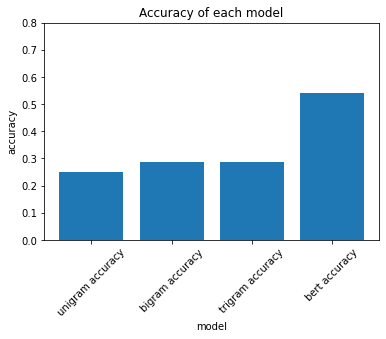

In [80]:
import matplotlib.pyplot as plt
plt.bar([df1.models[0], df1.models[1],df1.models[2],df1.models[3]],[df1.accuracy[0],df1.accuracy[1],df1.accuracy[2],df1.accuracy[3]])
plt.ylim((0.0,0.8))
plt.title('Accuracy of each model')
plt.xticks(rotation=45)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.show()

In [82]:
#calculating entropy
from scipy.stats import entropy
from keras import backend as K
import math
def entropy(probs):
    return -sum([max(prob)*np.log2(max(prob)) for prob in probs])

unigram_entropy = entropy(df2.probability[0])
bigram_entropy = entropy(df2.probability[1])
trigram_entropy = entropy(df2.probability[2])



In [85]:
#calculating perplexity
from keras import backend as K

unigram_perplexity = K.exp(unigram_entropy)
bigram_perplexity = K.exp(bigram_entropy)
trigram_perplexity = K.exp(trigram_entropy)

print("Perplexity of unigram is : " ,unigram_perplexity )
print("Perplexity of bigram is  : ", bigram_perplexity )
print("Perplexity of trigram is : ", trigram_perplexity )

Perplexity of unigram is :  tf.Tensor(2.117419065148431, shape=(), dtype=float64)
Perplexity of bigram is  :  tf.Tensor(4.459773119721743, shape=(), dtype=float64)
Perplexity of trigram is :  tf.Tensor(1.1447987861917384, shape=(), dtype=float64)


In [88]:
# dataframe for Entropy
data3 = {'models' :['unigram','bigram','trigram'],
         'entropy':[unigram_entropy,bigram_entropy,trigram_entropy]}
df3 = pd.DataFrame(data3)
df3




,models,entropy
0,unigram,0.750198
1,bigram,1.495098
2,trigram,0.135229


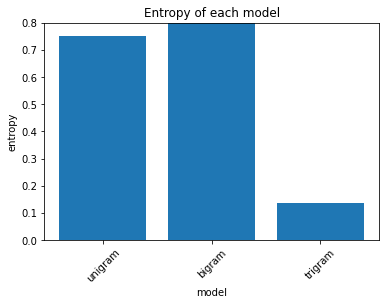

In [89]:
#bar plot for Entropy
import matplotlib.pyplot as plt
plt.bar([df3.models[0], df3.models[1],df3.models[2]],[df3.entropy[0],df3.entropy[1],df3.entropy[2]])
plt.ylim((0.0,0.8))
plt.title('Entropy of each model')
plt.xticks(rotation=45)
plt.xlabel('model')
plt.ylabel('entropy')
plt.show()

In [91]:
#dataframe for perplexity
data4 = {'models' :['unigram','bigram','trigram'],
         'perplexity':[unigram_perplexity,bigram_perplexity,trigram_perplexity]}
df4 = pd.DataFrame(data4)
df4

,models,perplexity
0,unigram,"tf.Tensor(2.117419065148431, shape=(), dtype=f..."
1,bigram,"tf.Tensor(4.459773119721743, shape=(), dtype=f..."
2,trigram,"tf.Tensor(1.1447987861917384, shape=(), dtype=..."
